In [1]:
import os
import shutil
import pickle
from PIL import Image
from hashlib import sha256
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator, image

from keras.applications.xception import Xception, decode_predictions
from keras.applications.xception import preprocess_input as preprocess_input_xce

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_incV3

from keras.applications.efficientnet import EfficientNetB7
from keras.applications.efficientnet import preprocess_input as preprocess_input_eff

### Variables

In [2]:
PIXELS = 600
path = './images/'
trainList = pd.read_csv('train.csv')
testList = pd.read_csv('test.csv')

### Find duplicated images

In [3]:
imgHashes = defaultdict(list)

def hashing(image):
    with Image.open(path + image) as f:
            imgHash = sha256(f.tobytes()).hexdigest()
            imgName = image
    return imgHash, imgName

for image in os.listdir(path):
    imgHash, imgName = hashing(image)
    imgHashes[imgHash].append(imgName)            

In [4]:
duplicated = []
duplicated_train = []

print('All duplicated set of images:')
for h256, imgs in imgHashes.items():
    if len(imgs) >= 2:
        duplicated += imgs
        print(f'{imgs[0]}, {imgs[1]}')
        for img in imgs:
            imgRead = mpimg.imread('images/'+ img)
            imgName = int(img.split('.')[0])
            if imgName in trainList.Id.values:
                duplicated_train.append(str(img))

print(f'\nDuplicated images in train set:\n{", ".join(duplicated_train)}')

All duplicated set of images:
0237.jpg, 4234.jpg
3458.jpg, 4162.jpg
5428.jpg, 7103.jpg
6624.jpg, 7469.jpg
6833.jpg, 8532.jpg
7063.jpg, 7196.jpg

Duplicated images in train set:
0237.jpg, 4234.jpg, 6833.jpg, 8532.jpg, 7063.jpg, 7196.jpg


### Check duplicated images

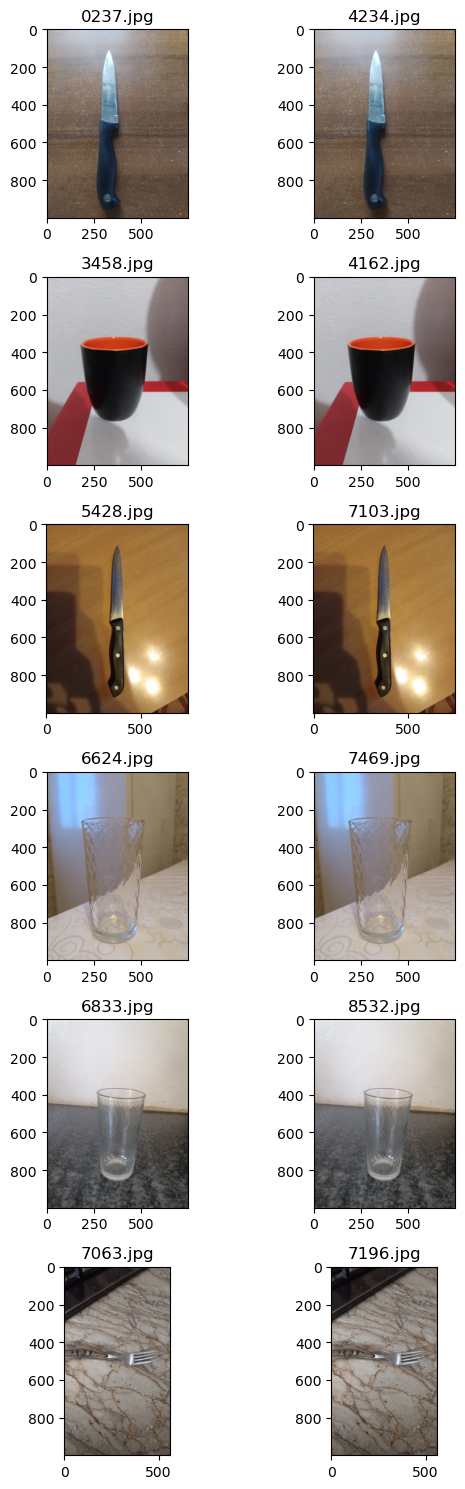

In [6]:
fig, ax = plt.subplots(6,2, figsize=(6, 15))

for img, ax in zip(duplicated, ax.ravel()):
    imgRead = mpimg.imread('images/'+ img)
    ax.imshow(imgRead)
    ax.set_title(img)

fig.tight_layout()

### Flip duplicated images only on the train set

In [7]:
images_to_flip = ['0237.jpg', '6833.jpg', '7063.jpg']

for img in images_to_flip:
    print(img)
    imgName = path + img 
    print(imgName)
    image = Image.open(path + img)
    print(image)
    img_rotated = image.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT)
    img_rotated.save(path + img )

0237.jpg
./images/0237.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1000 at 0x24BDEB5C400>
6833.jpg
./images/6833.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1000 at 0x24BDEB5C340>
7063.jpg
./images/7063.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=563x1000 at 0x24BDEB5C400>


### Verify images have been flipped

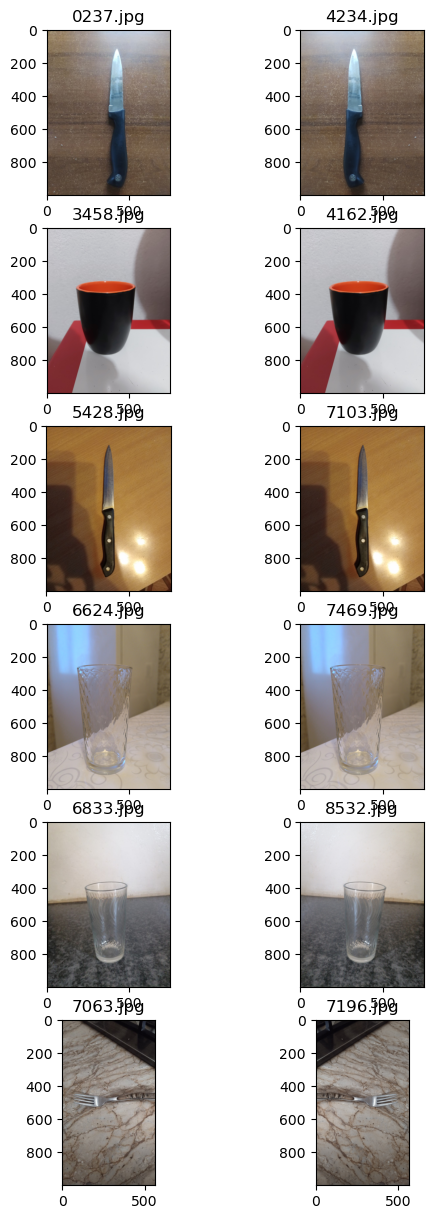

In [11]:
fig2, ax2 = plt.subplots(6,2, figsize=(6, 15))

for img, ax in zip(duplicated, ax2.ravel()):
    imgRead = mpimg.imread('images/'+ img)
    ax.imshow(imgRead)
    ax.set_title(img)

fig.tight_layout()

## Create directories and copy images

### Create directories

In [13]:
if not os.path.exists('./train'):
    os.mkdir('./train')
if not os.path.exists('./train/cup'):
    os.mkdir('./train/cup')     
if not os.path.exists('./train/fork'):
    os.mkdir('./train/fork')     
if not os.path.exists('./train/glass'):
    os.mkdir('./train/glass')     
if not os.path.exists('./train/knife'):
    os.mkdir('./train/knife')     
if not os.path.exists('./train/plate'):
    os.mkdir('./train/plate')     
if not os.path.exists('./train/spoon'):
    os.mkdir('./train/spoon')     
    
if not os.path.exists('./test'):
    os.mkdir('./test')

### Copy images to directories

In [14]:
for img in os.listdir('./images'):
    
    if (not os.path.exists(f'./train/{img}')) and (not(os.path.exists(f'./test/{img}'))):
        imgName = int(img.split('.')[0])
        
        if imgName in trainList.Id.values:
            
            imgLabel = trainList[trainList.Id == imgName].label.values
            
            if imgLabel == 'cup':
                shutil.copy(f'./images/{img}', f'./train/cup/{img}')
            elif imgLabel == 'fork':
                shutil.copy(f'./images/{img}', f'./train/fork/{img}')
            elif imgLabel == 'glass':
                shutil.copy(f'./images/{img}', f'./train/glass/{img}')
            elif imgLabel == 'knife':
                shutil.copy(f'./images/{img}', f'./train/knife/{img}')
            elif imgLabel == 'plate':
                shutil.copy(f'./images/{img}', f'./train/plate/{img}')
            elif imgLabel == 'spoon':
                shutil.copy(f'./images/{img}', f'./train/spoon/{img}')

        else:            
            
            shutil.copy(f'./images/{img}', f'./test/{img}')
            
totalTrainImgs = len(os.listdir("./train/cup")) + len(os.listdir("./train/fork")) + \
                len(os.listdir("./train/glass")) + len(os.listdir("./train/knife")) + \
                len(os.listdir("./train/plate")) + len(os.listdir("./train/spoon"))

totalTestImgs = len(os.listdir("./test"))

print(f'There is a total of {totalTrainImgs} images in the training set')
print(f'There is a total of {totalTestImgs} images in the test set')            

There is a total of 5559 images in the training set
There is a total of 3808 images in the test set


### Image Generators

In [16]:
def ProcInputs(modelName):
    
    preprocessInputs = {'Xception': preprocess_input_xce,
                    'InceptionV3': preprocess_input_incV3,
                    'efficientnetB7': preprocess_input_eff,
                   }
    return preprocessInputs[modelName]


def DataGenerators (modelName, split=0.2):
   
    preprocess_input = ProcInputs(modelName)
    
    dataGenerator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        validation_split=split,
                                      )    

    trainGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                         batch_size=32,
                                                         target_size=(PIXELS, PIXELS), 
                                                         subset="training",
                                                         shuffle=True,
                                                         class_mode='categorical')

    valGenerator = dataGenerator.flow_from_directory(directory='./train',
                                                       batch_size=16,
                                                       target_size=(PIXELS, PIXELS),
                                                       subset="validation",
                                                       shuffle=True,
                                                       class_mode='categorical')
    
    return trainGenerator, valGenerator

## Testing 3 different models
### Xception, InceptionV3 and EfficientNetB7

### Getting model configurations

In [17]:
def GetModel(modelName):
    
    basemodel_Xce = tf.keras.applications.Xception(weights='imagenet',
                                                   include_top=False,
                                                   input_shape=(PIXELS, PIXELS, 3))

    basemodel_Inc = tf.keras.applications.InceptionV3(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(PIXELS, PIXELS, 3))
    
    basemodel_EffB7 = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                       include_top=False,
                                                       input_shape=(PIXELS, PIXELS, 3)) 

   
    basemodels = {'Xception': basemodel_Xce,
                  'InceptionV3': basemodel_Inc,
                  'efficientnetB7': basemodel_EffB7,
                 }
    
    return basemodels[modelName]

### Building the model

In [18]:
def MakeModel(modelName = 'Xception', learning_rate = 0.001, size_inner=128, droprate=0.3):
    
    base_model = GetModel(modelName)
    
    base_model.trainable = False

    inputs = Input(shape=(PIXELS, PIXELS, 3))
    base = base_model(inputs, training=False)
    vectors = layers.GlobalAveragePooling2D()(base)
    
    inner = layers.Dense(size_inner, activation='relu')(vectors)
    drop = layers.Dropout(droprate)(inner)
    
    outputs = layers.Dense(6, activation='softmax')(drop)
    model = Model(inputs, outputs)
    
    optimizer = Adam(learning_rate=learning_rate)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

### Checkpointing

In [19]:
def GetCheckpoint(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint(modelName + '_{epoch:02d}_{val_accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')
    return checkpoint

def GetCheckpointFull(modelName):
    checkpoint = keras.callbacks.ModelCheckpoint(modelName + '_{epoch:02d}_{accuracy:.3f}.h5',
                                                 save_best_only=True,
                                                 #save_weights_only=True,
                                                 monitor='accuracy',
                                                 mode='max')
    return checkpoint


### Model preparation

In [23]:
def RunModel(learningRates, modelName, steps_per_epoch=50, epochs=10):
    
    scores = {}
    size = 128
    droprate = 0.3
    trainGenerator, valGenerator = DataGenerators (modelName)
    print()

    for lr in learningRates:
        print(f'Learning rate: {lr}')
        checkpoint = GetCheckpoint(modelName + '_' + f'lr{lr}')
        model = MakeModel(modelName=modelName, learning_rate=lr)
        history = model.fit(trainGenerator,
                            validation_data=valGenerator,
                            steps_per_epoch=steps_per_epoch,
                            epochs=epochs,
                            callbacks=[checkpoint])
        scores[lr] = history.history
        print('\n')
    
    return model, history, scores

### Plot history

In [ ]:
def PlotHistory(scores, lims=[0.9,0.98], xaxis=10):
        
    for lr , hist in scores.items():
        plt.plot(hist['val_accuracy'], label=lr)

    plt.xticks(np.arange(xaxis))
    plt.ylim(lims[0], lims[1])
    plt.legend()

### Finding best Learning rates for models

### Xception

In [ ]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'Xception'
model_X, history_X, scores_X = RunModel(learningRates, modelName)

Found 4450 images belonging to 6 classes.
Found 1109 images belonging to 6 classes.

Learning rate: 0.0004
Epoch 1/10
50/50 [==============================] - 31s 575ms/step - loss: 1.0006 - accuracy: 0.7156 - val_loss: 0.4899 - val_accuracy: 0.9243
Epoch 2/10
50/50 [==============================] - 28s 567ms/step - loss: 0.3982 - accuracy: 0.9057 - val_loss: 0.2802 - val_accuracy: 0.9432
Epoch 3/10
50/50 [==============================] - 29s 570ms/step - loss: 0.2709 - accuracy: 0.9319 - val_loss: 0.2127 - val_accuracy: 0.9540
Epoch 4/10
50/50 [==============================] - 29s 572ms/step - loss: 0.2145 - accuracy: 0.9506 - val_loss: 0.1849 - val_accuracy: 0.9549
Epoch 5/10
50/50 [==============================] - 29s 571ms/step - loss: 0.2094 - accuracy: 0.9484 - val_loss: 0.1810 - val_accuracy: 0.9459
Epoch 6/10
50/50 [==============================] - 30s 594ms/step - loss: 0.1845 - accuracy: 0.9488 - val_loss: 0.1544 - val_accuracy: 0.9576
Epoch 7/10
50/50 [=================

In [ ]:
PlotHistory(scores_X, lims=[0.9, 0.98], xaxis=2)

### InceptionV3

In [ ]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'InceptionV3'
model_IN, history_IN, scores_IN = RunModel(learningRates, modelName)

In [ ]:
PlotHistory(scores_IN, lims=(0.87, 0.96))

### EfficientnetB7

In [ ]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'efficientnetB7'
model_EN, history_EN, scores_EN = RunModel(learningRates, modelName)

In [ ]:
PlotHistory(scores_EN, lims=(0.95,0.99))

## Training the best model ( efficientnetB7 ) for longer and then tunning it

In [ ]:
modelName = 'efficientnetB7'
droprate = 0.3

base_model = GetModel(modelName)
base_model.trainable = False

inputs = Input(shape=(PIXELS, PIXELS, 3))
base = base_model(inputs, training=False)
vectors = layers.GlobalAveragePooling2D()(base)
inner = layers.Dense(64, activation='relu')(vectors)
drop = layers.Dropout(droprate)(inner)
outputs = layers.Dense(6, activation='softmax')(drop)
model = Model(inputs, outputs)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

In [ ]:
train, val = DataGenerators (modelName, split=0.2)

In [ ]:
loss0, accuracy0 = model.evaluate(val)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
initial_epochs = 20

checkpoint = GetCheckpoint(modelName)
history = model.fit(train,
                    #steps_per_epoch=50,
                    epochs=initial_epochs,
                    validation_data=val,
                   callbacks=[checkpoint])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Tunning the model

In [ ]:
base_model.trainable = True
base_model.summary()
#model = old_model


In [ ]:
old_model = model
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))


In [ ]:

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
learning_rate = 0.001/10
optimizer = Adam(learning_rate=learning_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


In [ ]:
model.summary()


In [ ]:
len(model.trainable_variables)

In [ ]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

history_fine2 = model.fit(train,
                         epochs=total_epochs,
                         steps_per_epoch=50,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=val,
                         callbacks=[checkpoint])

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
#########################################################

### All the models

In [ ]:
scores = {}
lr = 0.001
size = 128
droprate = 0.3
models = ['Xception', 'InceptionV3', 'efficientnetB7', 'ResNet50V2', 'VGG16']

for modelName in models:
    trainGenerator, valGenerator = DataGenerators (modelName)
    checkpoint = GetCheckpoint(modelName)
    model = MakeModel(modelName=modelName, learning_rate=lr, size_inner=size, droprate=droprate)
    history = model.fit(trainGenerator, validation_data=valGenerator, steps_per_epoch=50, epochs=15, callbacks=[checkpoint])
   

### ResNet50V2

In [ ]:
learningRates = [0.0004, 0.0007, 0.001]
modelName = 'ResNet50V2'
model_RN, history_RN, scores_RN = RunModel(learningRates, modelName)

In [ ]:
PlotHistory(scores_RN, lims=(0.9,0.99))

### VGG16

In [ ]:
learningRates = [0.0005, 0.001, 0.005]
modelName = 'VGG16'
model_VGG, history_VGG, scores_VGG = RunModel([0.001], modelName,steps_per_epoch=50, epochs=40)

In [ ]:
PlotHistory(scores_VGG, lims=(0.8,0.99), xa)

### Predict test labels

In [ ]:
size = 16
droprate = 0.3
modelName = 'Xception'
newModel = model
newModel.load_weights('Xception_32_0.982.h5')

In [ ]:
count =0
res = []
classes = train.class_indices
labels = dict((v, k) for k, v in classes.items())


preprocessInput = ProcInputs(modelName)
    
for file in os.listdir('./test'):
    imgPath = './test/' + file
    img = image.load_img(imgPath, target_size=(PIXELS, PIXELS))
    x = np.array(img)
    X = np.array([x])
    X = preprocessInput(X)
    preds = newModel.predict(X)

    label = labels[np.argmax(preds[0])]
    Id = file.split('.')[0]
    res.append([Id, label])
    if count%400==0:
        print(count, Id, label)
    count += 1

In [ ]:
results = pd.DataFrame(res, columns=['Id', 'label'])
results

results.to_csv('submission_Xception_32_0.982_20xdef+20x10_10th_tunnedExtra.csv', index=False)

In [ ]:
#####################

In [ ]:
#newModel2 = MakeModel(modelName='Xception', learning_rate=0.001, size_inner=16, droprate=0.3)
#newModel2.load_weights('Xception_27_0.977.h5')
# 
#newModel1 = MakeModel(modelName='efficientnetB7', learning_rate=0.001, size_inner=16, droprate=0.3)
#newModel1.load_weights('efficientnetB7_13_0.984.h5')
#newModel3 = MakeModel(modelName='Xception', learning_rate=0.001, size_inner=size, droprate=droprate)
#newModel3.load_weights('Models/Xception_lr0.001_10_0.976.h5')
#newModel4 = MakeModel(modelName='VGG16', learning_rate=0.001, size_inner=size, droprate=droprate)
#newModel4.load_weights('Models/VGG16_lr0.001_29_0.939.h5')

In [ ]:
count =0
res = []
classes = trainGenerator.class_indices
labels = dict((v, k) for k, v in classes.items())


for file in os.listdir('./test'):
    imgPath = './test/' + file
    img = image.load_img(imgPath, target_size=(PIXELS, PIXELS))
    x = np.array(img)
    X = np.array([x])
    X = preprocess_input_xce(X)
    preds1 = newModel1.predict(X)
    preds2 = newModel2.predict(X)
    #preds3 = newModel3.predict(X)
    #preds4 = newModel4.predict(X)
    preds = preds1 * 0.35 + preds2 * 0.35# + preds3 * 0.2 + preds4 * 0.1 
    
    label = labels[np.argmax(preds[0])]
    Id = file.split('.')[0]
    res.append([Id, label])
    if count%400==0:
        print(count, Id, label)
    count += 1

In [ ]:
results = pd.DataFrame(res, columns=['Id', 'label'])
results

results.to_csv('submission_full_combo.csv', index=False)

In [ ]:
trainGenerator, valGenerator = DataGenerators ('Xception')

In [ ]:
import matplotlib.image as mpimg

for img in os.listdir('./images/'):
    print(img)
    #Image.open(filepath).load()
    a = mpimg.imread('images/'+ img)
    plt.imshow(a)
    break
        #imgH

In [ ]:
for directory in os.listdir('./train'):
    print(directory)

In [ ]:
from PIL import Image

In [ ]:
from PIL import Image
from hashlib import sha1

path = './imgs/'

imgHashes = defaultdict(list)

def hashing(image):
#    pass
    with Image.open(path + image) as f:
            imgHash = sha1(f.tobytes()).hexdigest()
            imgName = int(image.split('.')[0])
    return imgHash, imgName

# Read image
#for image in os.listdir(path):
#    with Image.open(path + image) as f:
#            imgHash = md5(f.tobytes()).hexdigest()
#            imgName = int(image.split('.')[0])
#            #print(imgName)
            #if imgName in testList.Id.values:
                #print(imgName)
                
            #imgHashes[imgHash].append(imgName)

for image in os.listdir(path):
    imgHash, imgName = hashing(image)
    imgHashes[imgHash].append(imgName)            

#imgHash = f,img_hash
#img = Image.open('images/0000.jpg')
#print(f)
#print(img_hash)
#img_hash = md5(img).hexdigest()

# Output Images
#img.show()
 
# prints format of image
#print(img.format)
#print(img.filename)
 
# prints mode of image
#print(img.mode)

In [ ]:
for i,j in imgHashes.items():
    if len(j) >= 2:
        print(j,i)
        for jj in j:
            #print(jj in testList.Id.values)
            print(jj in trainList.Id.values)

In [ ]:
imgHashes

In [ ]:
for img in os.listdir(path):
    print(img)
    image = Image.open(path + img)
    print(image)
    image_rot_180 = image.transpose(Image.FLIP_LEFT_RIGHT)
    image_rot_180.save(path + 'new_' + img )

In [ ]:
from pathlib import Path

project_dir = Path('.')
img_dir = project_dir / 'images'


hash_dict = defaultdict(list)
for image in img_dir.glob('*.jpg'):

    with image.open('rb') as f:
        img_hash = md5(f.read()).hexdigest()
        hash_dict[img_hash].append(image)

In [ ]:
x = set(hash_dict.keys())
(x)


In [ ]:
len(set(tuple(hash_dict.values())))

In [ ]:
duplicate_img = []
for k, v in hash_dict.items():
    if len(v) > 1:
        
        if v[0].name != v[1].name:
            print('----')
            print(k)
            print(v)
            duplicate_img.append(v[0].name)
            duplicate_img.append(v[1].name)
            
duplicate_img

In [ ]:
testList = pd.read_csv('test.csv')
testList.Id.values

In [ ]:
678 in testList.Id.values